<a href="https://colab.research.google.com/github/jeju2507/2025_mirae_master/blob/main/3%EC%9D%BC%EC%B0%A8_%EB%B0%94%EC%9D%B4%EB%B8%8C%EC%BD%94%EB%94%A9_%EB%AA%A8%EB%91%90%EC%9D%98%EA%B4%91%EC%9E%A5_%EC%9B%B9%ED%81%AC%EB%A1%A4%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 웹 크롤링하여 데이터 분석하기
정적크롤링



---



- **(코랩에서)한글폰트 설치하기**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 런타입 > 세션 다시 시작

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,857 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and dire



---



## 1.타겟 데이터
- 모두의 광장: https://modu.pcpp.go.kr/
- 데이터 크롤링 타겟:  https://modu.pcpp.go.kr/suggest-board?sortType=recent&limit=30#proposal_list_anchor

## 2.작업 순서
- 웹 크롤링하기
    1. 구글 드라이브 마운트
    2. Selenium 설치 & 내 구글 드라이브에 chromedriver 설치(최초1번)
    3. 실행준비(chrome_options 설정)
    4. 크롤링 실행
- 데이터 분석
    1. `제목` 형태소 분석하기
    2. `제목` 워드클라우드로 나타내기
    



---



## 3.웹 크롤링하기

### 3-1.구글 드라이브 마운트
- 내드라이브연결


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 3-2.Selenium 설치 & chromedriver 설치
(내 구글 드라이브에 chromedriver 설치, chromedriver는 최초 1회)

In [2]:
# 파이썬 버전
!python --version

Python 3.11.13


In [3]:
# 셀레니엄 설치
!pip install selenium
!apt-get update

# (최초 1회)
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks' # 자기가 저장하고 싶은 위치
!pip install chromedriver-autoinstaller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 10.6 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,471 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,574 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,152 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages 

In [4]:
# 크롬 드라이버 설치 확인
!which chromedriver

/usr/bin/chromedriver


In [5]:
# 크롬 브라우저 설치 확인
!which chromium-browser

/usr/bin/chromium-browser


In [6]:
# 셀레니엄 버전
import selenium
print(selenium.__version__)

4.34.2


### 3-3. 실행준비

- 라이브러리 가져오기

In [7]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from urllib.request import urlretrieve

import chromedriver_autoinstaller  # setup chrome options
import sys
import urllib.request
import os
import time

import pandas as pd
from datetime import datetime

- chrome_options 설정 등

In [8]:
chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"

# --- 크롬 옵션 설정 ---
sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')  # set path to chromedriver as per your configuration
chrome_options.add_argument('lang=ko_KR') # 한국어

chrome_options.add_argument('--disable-gpu') # GPU 사용 비활성화
chrome_options.add_argument('--window-size=1920,1080') # 창 크기 설정
chrome_options.add_argument('--remote-debugging-port=9222') # 디버깅 포트 (필요 시)

chromedriver_autoinstaller.install()  # set the target URL

### 3-4. 크롤링 실행

In [11]:
# -------- 설정값 --------
max_count = 1000  # 크롤링할 총 데이터 수
per_page = 100    # 페이지당 게시글 수
# ------------------------

print("3단계: WebDriver 초기화를 시도 중...")
try:
    driver = webdriver.Chrome(options=chrome_options)
    print("WebDriver 초기화 성공!")
except Exception as e:
    print(f"!!! 치명적인 오류: WebDriver 초기화 실패. 오류: {e} !!!")
    print("이 오류는 주로 ChromeDriver와 Chromium 버전 불일치 또는 환경 문제 때문에 발생합니다.")
    print("Colab 런타임이 최신 상태인지 확인하고 셀을 다시 실행해주세요.")
    # 오류 발생 시 스크립트 강제 종료
    exit()

titles = []
descriptions = []
dates = []
goods = []
page = 1

while len(titles) < max_count:

    url = f"https://modu.pcpp.go.kr/suggest-board?page={page}&limit={per_page}&sortType=recent#proposal_list_anchor"
    driver.get(url)
    time.sleep(3)

    # 카드형 제목 요소 추출
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-body > a > p.tit > span')
    for card in cards:
        title = card.text.strip()
        if title:
            titles.append(title)
            if len(titles) >= max_count:
                break

    # 카드형 내용 요소 추출
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-body > a > p.txt')
    for card in cards:
        desc = card.text.strip()
        if desc:
            descriptions.append(desc)
            if len(descriptions) >= max_count:
                break

    # 카드형 날짜 요소 추출
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-btm > span')
    for card in cards:
        dt = card.text.strip()
        if dt:
            dates.append(dt)
            if len(dates) >= max_count:
                break

    # 카드형 좋아요 요소 추출
    cards = driver.find_elements(By.CSS_SELECTOR, 'div.card-btm > div > p:nth-child(1) > span')
    for card in cards:
        good = card.text.strip()
        if good:
            goods.append(good)
            if len(goods) >= max_count:
                break
    print(f"현재 페이지: {page} {len(titles)}건")
    page += 1

# 드라이버 종료
driver.quit()

# 결과 출력
print(f"총 {len(titles)}건의 제목을 추출했습니다.\n")
# for i, title in enumerate(titles, 1):
#     print(f"{i:03d}. {title}")



## 데이터 저장하기
# 리스트들을 딕셔너리로 묶기
print('4단계: Pandas표로 출력하기')
data = {
    "제목": titles,
    "등록일": dates,
    "좋아요": goods,
    "내용": descriptions,
}

# 데이터프레임으로 변환
df = pd.DataFrame(data)

# 결과 출력
display(df.head())

# 파일로 출력
print('5단계: 파일로 저장하기')
now = datetime.now()
formatted_time = now.strftime("%Y-%m-%d_%H%M")
filename = f'모두의광장_제안_{formatted_time}.csv'
df.to_csv(filename)

3단계: WebDriver 초기화를 시도 중...
WebDriver 초기화 성공!
현재 페이지: 1 100건
현재 페이지: 2 200건
현재 페이지: 3 300건
현재 페이지: 4 400건
현재 페이지: 5 500건
현재 페이지: 6 600건
현재 페이지: 7 700건
현재 페이지: 8 800건
현재 페이지: 9 900건
현재 페이지: 10 1000건
총 1000건의 제목을 추출했습니다.

4단계: Pandas표로 출력하기


,제목,등록일,좋아요,내용
0,"밀폐공간 작업 중 질식, 중독사고 예방 방안(장비대여 서비스)",2025.07.29,0,지자체가 안전장비를 확보해 무료 또는 저렴한 비용으로 대여해 주는 공공 안전장비 공...
1,[탈수급 후 채권추심이 재개된 구조와 제도 개선 필요성],2025.07.29,0,1. 문제의 발생 배경 2005년 한국자산관리공사(이하 ‘캠코’)는 정부의 생계형 ...
2,강력범죄로부터 우리 아이들과 가족을 지키기 위한 초강력 형벌과 선제적 치안 시스템 ...,2025.07.29,0,요즘 대한민국은 하루에도 몇 건씩 여성과 아이들을 대상으로 한 강력범죄가 끊이지 않...
3,지역균형발전을 위한 임무 중심 R&BD 체계 전환 정책 제안,2025.07.29,0,1. 제안 배경 대한민국의 연구개발(R&D) 예산은 심각한 수준으로 수도권에 집중되...
4,약국 간 의약품 가격편차 완화 및 소비자 권장가격 표시제 도입 정책 제안,2025.07.29,0,1. 제안취지 ㄱ) 가정에서 자주 사용하는 일반약·건강기능식품의 가격정보 부족 해결...


5단계: 파일로 저장하기




---



## 4.데이터 분석

- 라이브러리 설치

In [20]:
!pip install konlpy wordcloud matplotlib pandas scikit-learn > /dev/null

일별 좋아요수를 막대그래프로 표시

### 4-1.등록일별 데이터 통계
-일별제안건수

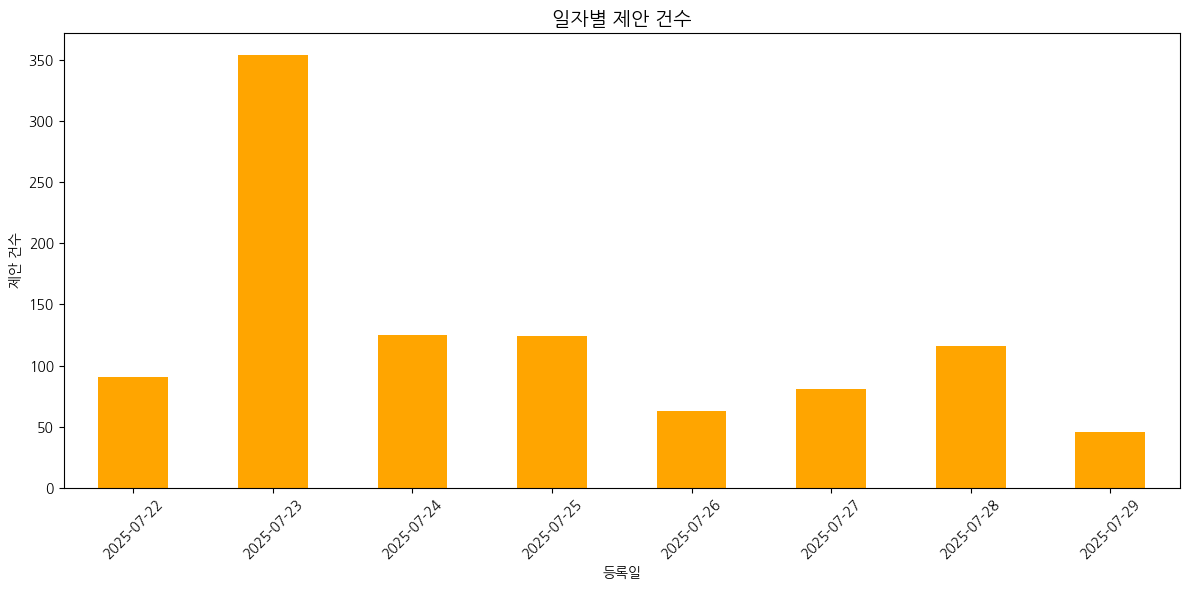

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로 (Colab의 경우 경로 조정 필요)
file_path = '/content/모두의광장_제안_2025-07-29_0447.csv'
df = pd.read_csv(file_path)

# 등록일을 날짜 타입으로 변환
df['등록일'] = pd.to_datetime(df['등록일'])

# 일자별 제안 건수 계산
proposal_counts = df.groupby(df['등록일'].dt.date).size()

# 막대그래프 그리기
plt.figure(figsize=(12, 6))
proposal_counts.plot(kind='bar', color='orange')
plt.title('일자별 제안 건수', fontsize=14)
plt.xlabel('등록일')
plt.ylabel('제안 건수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


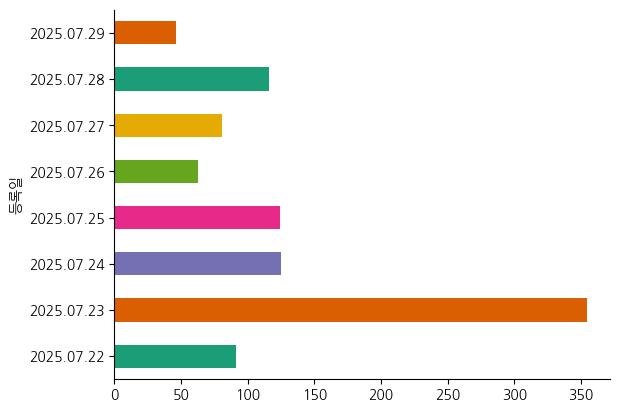

In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# matplotlib에서 기본 폰트로 지정
plt.rcParams['font.family'] = 'NanumGothic'

df.groupby('등록일').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()



### 4-2.`좋아요` 컬럼 내림차순 정렬하기

In [19]:
# df `좋아요` 컬럼 내림차순 정렬하기
df_sorted = df.sort_values(by='좋아요', ascending=False)
display(df_sorted.head())

,Unnamed: 0,제목,등록일,좋아요,내용
142,142,민주시민 양성 및 교육평등 실현을 위한 학교도서관 활성화,2025-07-28,874,1. 제안취지 - 학생들의 비판적 사고 능력을 키우고 교육 격차를 해소하기 위해 학...
599,599,어린이·사회복지급식관리지원센터 예산 절감 및 효율적 운영에 관한 정책 제안입니다.,2025-07-23,746,Ⅰ. 제안배경 및 목적 어린이·사회복지급식관리지원센터(이하 센터라 함)는 2011년...
986,986,건강한 교육 급식 환경 개선을 위해 영양교사 확대 배치가 필요합니다,2025-07-22,336,안녕하세요? 저는 현재 영양교사로 재직 중입니다. 작년 서울의 한 중학교 영양교사가...
942,942,지체장애인교사가 대통령 및 정부에 드리는 호소문,2025-07-22,198,존경하는 대통령님과 정부 관계자 여러분께 안녕하십니까. 저는 경기도에서 17년째 아...
143,143,주 4.5일제를 대비한 공공도서관 자원확충,2025-07-28,185,1. 제안 취지 - 공공·민간 부문을 중심으로 주 4.5일 근무제 도입이 본격적으로...


### 4-3. `제목` 형태소 분석하기

- 형태소 분석 + 명사 추출

In [21]:
# 형태소 분석 + 명사 추출
def stemming(titles):
    from konlpy.tag import Okt
    from collections import Counter

    okt = Okt()

    # 제목 전체를 하나의 텍스트로 결합
    full_text = " ".join(titles)

    # 명사 추출
    nouns = okt.nouns(full_text)

    # 불용어 제거 (예: 너무 짧은 단어)
    words = [word for word in nouns if len(word) > 1]

    # 빈도 계산
    word_counts = Counter(words)

    return word_counts


# 제목 컬럼 추출
titles = df["제목"].dropna().tolist()

# 형태소 분석 + 명사 추출
word_counts = stemming(titles)

# 딕셔너리에서 top10개 추출
top10 = dict(word_counts.most_common(10))
print(top10)


{'제안': 222, '정책': 199, '개선': 160, '전환': 92, '아파트': 90, '민간': 88, '건의': 85, '해소': 85, '임대': 83, '분양': 83}


### 4-4. 워드클라우드 시각화

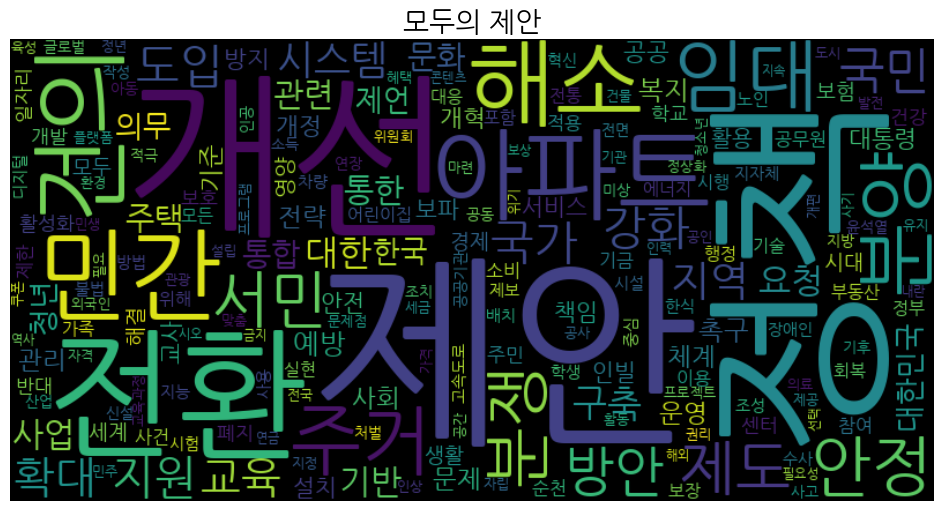

In [24]:
# ✅ STEP 2: 워드클라우드 시각화
def display_wordcloud(word_counts):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    # 폰트 경로 설정
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

    # matplotlib에서 기본 폰트로 지정
    plt.rcParams['font.family'] = 'NanumGothic'

    # 예시 단어 빈도수 (word_counts는 실제 데이터로 대체하세요)
    # 예시:
    # from collections import Counter
    # word_counts = Counter({'청년': 20, '주택': 18, '공동체': 10})

    # 워드클라우드 생성
    wc = WordCloud(font_path=font_path, width=800, height=400, background_color='black')
    wc_img = wc.generate_from_frequencies(word_counts)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.imshow(wc_img, interpolation='bilinear')
    plt.axis('off')
    plt.title("모두의 제안", fontsize=20, fontweight=10)
    plt.show()

    # 이미지 파일로 저장하기
    # 폴더에 해당 이미지 파일이 있으면 다른 이름으로 이미지 파일 만들기
    imagefile = '워드클라우드.png'
    count = 1
    while os.path.exists(imagefile):
        imagefile = f'워드클라우드_{count}.png'
        count += 1
    wc.to_file(imagefile)


display_wordcloud(word_counts)



---



- 토큰화 한 결과

상위 10개 단어 (불용어 제거 후):
[('제안', np.int64(147)), ('있습니다', np.int64(141)), ('5년', np.int64(136)), ('분양전환', np.int64(126)), ('위한', np.int64(100)), ('정책', np.int64(96)), ('배경', np.int64(94)), ('현재', np.int64(92)), ('저희', np.int64(91)), ('조건으로', np.int64(87))]


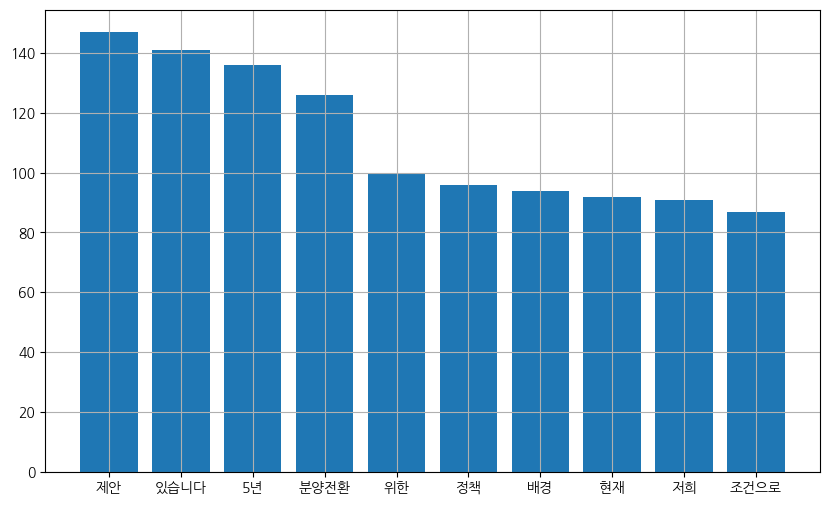

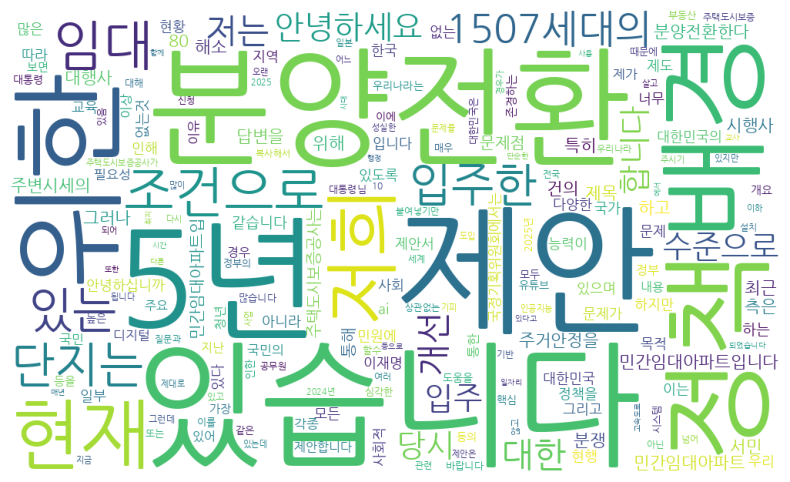

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# 말뭉치를 토큰화하여 빈도수 가져오기
def get_wordTokenCount(corpus):
    import numpy as np
    from sklearn.feature_extraction.text import CountVectorizer

    # 불용어 목록 (제외할 단어들)
    # 제거목록 = ['제안', '있습니다', '현재', '배경', '안녕하세요', '있는', '저는', '정책', '합니다', '위한']
    제거목록 = []

    # 말뭉치 벡터화
    vect = CountVectorizer().fit(corpus)
    count = vect.transform(corpus).toarray().sum(axis=0)

    # 토큰 빈도수 정렬
    idx = np.argsort(-count)
    count = count[idx]
    feature_name = np.array(vect.get_feature_names_out())[idx]

    # ❗️제거목록을 적용한 필터링
    mask = ~np.isin(feature_name, 제거목록)
    filtered_feature_name = feature_name[mask]
    filtered_count = count[mask]

    # 상위 10개 출력
    print("상위 10개 단어 (불용어 제거 후):")
    print(list(zip(filtered_feature_name, filtered_count))[:10])

    return filtered_feature_name, filtered_count


# 단어(토큰) 빈도수 막대 그래프 그리기
def draw_wordTokenCountGraph(data, freq):
    plt.bar(data, freq)
    plt.grid()
    plt.show()

    # 그래프 그림 저장히기
    plt.savefig(f'./token_bar_graph.png')

# 워드클라우드 만들기
def make_wordcloud(feature_name, count):
    # 한글 폰트 경로를 설정
    # font_path = 'C:/Windows/Fonts/malgun.ttf'    # Windows 환경일 경우 폰트 위치
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 코랩에서 폰트 위치

    # (토큰명, 빈도수) 딕셔너리 타입으로 변환
    data = dict(zip(feature_name, count))

    # 워드클라우드로 그래프로 시각화
    wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_path)
    plt.imshow(wc.generate_from_frequencies(data)) #딕셔너리
    plt.axis("off")
    plt.show()

    # 이미지 파일로 저장하기
    imagefile = '워드클라우드.png'
    count = 1
    while os.path.exists(imagefile):
        imagefile = f'워드클라우드_{count}.png'
        count += 1
    wc.to_file(imagefile)


# 1.텍스트 말뭉치(corpus) 데이터 지정하기
corpus = df['내용'].to_list()
# print(corpus)

# 2.말뭉치를 토큰화하여 빈도수 가져오기
feature_name, count = get_wordTokenCount(corpus)

# 3.단어(토큰) 빈도수 막대 그래프 그리기(상위 10개)
draw_wordTokenCountGraph(feature_name[:10], count[:10])

# 4.워드 클라우드 만들기
make_wordcloud(feature_name, count)

### 4-5. 핵심 키워드 추출
(KeyBERT를 활용한 문맥 기반 키워드 추출)

In [25]:
# 1단계: KeyBERT 및 관련 라이브러리 설치
!pip install -q keybert
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00


In [26]:
# 2단계: 모델 불러오기 및 키워드 추출
from keybert import KeyBERT

# 한국어도 잘 지원되는 다국어 모델 사용
kw_model = KeyBERT(model='paraphrase-multilingual-MiniLM-L12-v2')

# 예시 문장
doc = "저는 청년 주거 문제를 해결하기 위한 정책을 제안합니다. 특히 공동체 주택에 대한 관심이 필요합니다."

# 키워드 추출
keywords = kw_model.extract_keywords(
    doc,
    keyphrase_ngram_range=(1, 2),  # 1~2단어 키워드
    stop_words=['제안', '합니다', '있습니다', '필요합니다'],  # 한국어 불용어
    top_n=10
)

# 결과 출력
for i, (kw, score) in enumerate(keywords, 1):
    print(f"{i:02d}. {kw} (score: {score:.4f})")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

01. 공동체 주택에 (score: 0.6211)
02. 주택에 대한 (score: 0.5883)
03. 정책을 제안합니다 (score: 0.4878)
04. 주거 문제를 (score: 0.4351)
05. 주택에 (score: 0.4319)
06. 특히 공동체 (score: 0.4169)
07. 공동체 (score: 0.4139)
08. 위한 정책을 (score: 0.3849)
09. 제안합니다 특히 (score: 0.3374)
10. 정책을 (score: 0.3280)


- 모두의 제안 건별 핵심 키워드 추출

In [27]:
df_keyword = df.copy()
for i, doc in enumerate(df['제목'].to_list(), 0):
    print(f"\n문장 {i}: {doc}")
    keywords = kw_model.extract_keywords(doc, top_n=5, keyphrase_ngram_range=(1,2))
    for idx, (kw, score) in enumerate(keywords):
        print(f" - {kw}: {score:.4f}")
        # 컬럼에 추가
        df_keyword.loc[i, f'keyword{idx}'] =  kw
        df_keyword.loc[i, f'keyword_p{idx}'] = score

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 - 국민신문고에: 0.4907

문장 260: 어르신들의 건강한 한끼는 지자체가 책임집시다
 - 어르신들의 건강한: 0.9253
 - 지자체가 책임집시다: 0.8481
 - 책임집시다: 0.8263
 - 건강한 한끼는: 0.7880
 - 한끼는 지자체가: 0.7781

문장 261: 검찰개혁: 무리한 수사(경찰) 및 기소(검찰) 방지를 위한 정책 제안안
 - 검찰개혁 무리한: 0.8325
 - 검찰개혁: 0.8308
 - 검찰 방지를: 0.7752
 - 기소 검찰: 0.7733
 - 검찰: 0.7244

문장 262: 사회 불안과 분열을 야기하는 극우 세력
 - 사회 불안과: 0.8125
 - 야기하는 극우: 0.7168
 - 불안과 분열을: 0.6570
 - 분열을 야기하는: 0.6176
 - 극우 세력: 0.5953

문장 263: 세계적 미술도서관을 꿈꾸며
 - 세계적 미술도서관을: 0.9332
 - 미술도서관을 꿈꾸며: 0.9272
 - 미술도서관을: 0.8383
 - 세계적: 0.5501
 - 꿈꾸며: 0.4208

문장 264: 출산장려정책과 정년 연장에 관한 의견(정년 65세 연장)
 - 65세 연장: 0.6727
 - 65세: 0.5402
 - 정년 65세: 0.4148
 - 출산장려정책과: 0.3457
 - 의견 정년: 0.3428

문장 265: 경찰기피 소방선호 이유~~~~^^
 - 경찰기피 소방선호: 0.6051
 - 경찰기피: 0.5610
 - 소방선호 이유: 0.5282
 - 소방선호: 0.4865
 - 이유: 0.4009

문장 266: 교통신호체계점검
 - 교통신호체계점검: 1.0000

문장 267: 국민신문고 데이터 및 공공 트랙백 기반을 통한 사회혁신 오픈플랫폼 제공을 통해 청년 일자리 창출
 - 사회혁신 오픈플랫폼: 0.6410
 - 청년 일자리: 0.5944
 - 국민신문고 데이터: 0.5927
 - 통한 사회혁신: 0.5763
 - 사회혁신: 0.5428


- 파일로 저장

In [28]:
display(df_keyword.head())
df_keyword.to_csv(filename + '_keyword.csv')

,Unnamed: 0,제목,등록일,좋아요,내용,keyword0,keyword_p0,keyword1,keyword_p1,keyword2,keyword_p2,keyword3,keyword_p3,keyword4,keyword_p4
0,0,"밀폐공간 작업 중 질식, 중독사고 예방 방안(장비대여 서비스)",2025-07-29,0,지자체가 안전장비를 확보해 무료 또는 저렴한 비용으로 대여해 주는 공공 안전장비 공...,중독사고 예방,0.7431,예방 방안,0.6151,중독사고,0.6136,질식 중독사고,0.6132,예방,0.5779
1,1,[탈수급 후 채권추심이 재개된 구조와 제도 개선 필요성],2025-07-29,0,1. 문제의 발생 배경 2005년 한국자산관리공사(이하 ‘캠코’)는 정부의 생계형 ...,탈수급 채권추심이,0.7479,채권추심이 재개된,0.6466,제도 개선,0.6303,구조와 제도,0.5645,재개된 구조와,0.5575
2,2,강력범죄로부터 우리 아이들과 가족을 지키기 위한 초강력 형벌과 선제적 치안 시스템 ...,2025-07-29,0,요즘 대한민국은 하루에도 몇 건씩 여성과 아이들을 대상으로 한 강력범죄가 끊이지 않...,형벌과 선제적,0.6000,강력범죄로부터 우리,0.5787,초강력 형벌과,0.5422,형벌과,0.5385,강력범죄로부터,0.5339
3,3,지역균형발전을 위한 임무 중심 R&BD 체계 전환 정책 제안,2025-07-29,0,1. 제안 배경 대한민국의 연구개발(R&D) 예산은 심각한 수준으로 수도권에 집중되...,지역균형발전을 위한,0.7327,지역균형발전을,0.7031,전환 정책,0.6308,정책 제안,0.5713,체계 전환,0.5198
4,4,약국 간 의약품 가격편차 완화 및 소비자 권장가격 표시제 도입 정책 제안,2025-07-29,0,1. 제안취지 ㄱ) 가정에서 자주 사용하는 일반약·건강기능식품의 가격정보 부족 해결...,의약품 가격편차,0.8161,약국 의약품,0.6274,소비자 권장가격,0.5956,권장가격 표시제,0.5614,의약품,0.5161


### 4-6 핵심키워드 워드클라우드 표현하기

WordTop10: {'분양': 70, '전환': 70, '분쟁': 41, '아파트': 40, '민간': 36, '임대': 34, '정책': 24, '제안': 19, '국가': 17, '제도': 15}


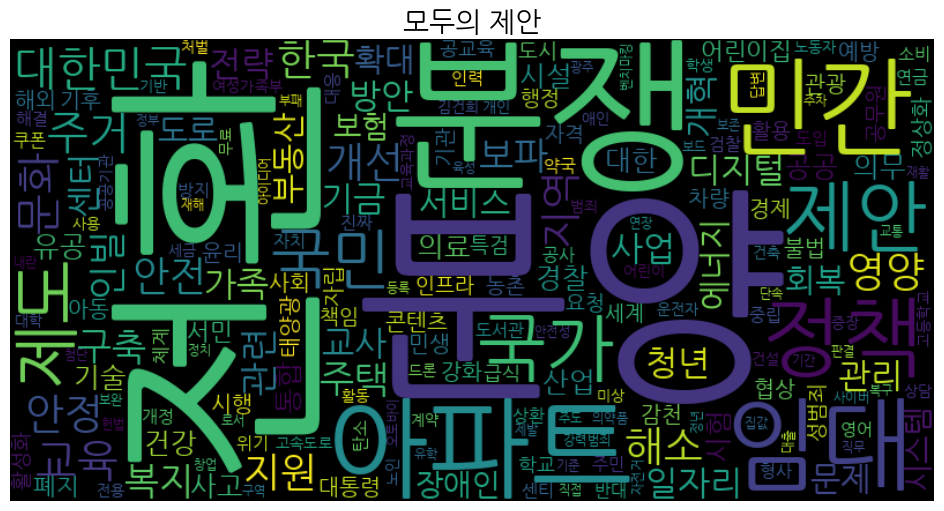

In [29]:
# 형태소 분석 + 명사
word_counts = stemming(df_keyword['keyword1'].dropna().to_list())
print(f'WordTop10: {dict(word_counts.most_common(10))}')

# 워드클라우드 시각화
display_wordcloud(word_counts)
